In [1]:
import numpy as np
import os

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.misc import imsave

from depth_image import DepthImage

import cv2
import imageio
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

In [2]:
kResX = 320
kResY = 240

# """
# Projection formulas as described in
# https://groups.google.com/forum/#!msg/unitykinect/1ZFCHO9PpjA/1KdxUTdq90gJ.
# Given (x,y,z) coordinates, converts that point into its x pixel number in the 2D image.
# """
# def xPixelFromCoords(x, y, z):
#     kRealWorldXtoZ = 1.122133
#     fCoeffX = kResX / kRealWorldXtoZ
#     xPixel = (fCoeffX * float(x) / float(z)) + (kResX / 2)
#     return int(xPixel)

# """
# Given (x,y,z) coordinates, converts that point into its y pixel number in the 2D image.
# """
# def yPixelFromCoords(x, y, z):
#     kRealWorldYtoZ = 0.84176
#     kResY = 240
#     fCoeffY = kResY / kRealWorldYtoZ
#     yPixel = (kResY / 2) - (fCoeffY * float(y) / float(z))
#     return int(yPixel)

def pixel_from_coords(x, y, z):
    kRealWorldXtoZ = 1.122133
    kRealWorldYtoZ = 0.84176
    fCoeffX = kResX / kRealWorldXtoZ
    fCoeffY = kResY / kRealWorldYtoZ
    xPixel = (fCoeffX * float(x) / float(z)) + (kResX / 2)
    yPixel = (kResY / 2) - (fCoeffY * float(y) / float(z))
    return int(xPixel), int(yPixel)

In [3]:
def read_skels(folder_name='.'):
    result = {}
    for dirName, subdirList, fileList in os.walk(folder_name, topdown=False):
        for fname in fileList:
            if fname.endswith('.txt'):                
                with open(os.path.join(dirName, fname)) as f:
                    content = [line.rstrip() for line in f.readlines()] # strip whitespace
                    frame_coords = {}
                    for line in content:
                        frame_num, skeleton_coords = parse_skeleton_text(line)
                        frame_coords[frame_num] = skeleton_coords # TODO: add more
                    video_id = os.path.splitext(fname)[0].split("joints_")[1]
                    result[video_id] = frame_coords                        
    return result

def parse_skeleton_text(line, num_joints=20):    
    # Parse line by comma
    fields = line.split('  ')
    assert len(fields) == 61, 'Actual length is: ' + str(len(fields))
    
    frame_num = int(fields[0])
    skeleton_coords = [] 

    offset = 1
    for joint_id in range(0, num_joints): # 1, 2,...,11
        x = fields[offset]
        offset += 1
        y = fields[offset]
        offset += 1
        z = fields[offset]
        offset += 1

        pixel_x, pixel_y = pixel_from_coords(x, y, z)
        skeleton_coords.append((pixel_x, pixel_y))    
    assert len(skeleton_coords) == num_joints, 'Actual length is: ' + str(len(skeleton_coords))
    return frame_num, skeleton_coords # ",".join((str(v) for v in output))

In [4]:
skel_dir_ = 'UTKinect-Action3D/joints'
skeletons = read_skels(skel_dir_)

In [5]:
def read_rgb_imgs(folder_name='.', overlay_skeleton=True):
    for dirName, subdirList, fileList in os.walk(folder_name, topdown=False):
        for fname in fileList:
            if fname.endswith('.jpg') and fname.startswith('colorImg'):
                video_id = os.path.basename(os.path.normpath(dirName))
                print("Video ID: ", video_id)

                frame_num = int(os.path.splitext(fname)[0].split('colorImg')[1])

                im_path = os.path.join(dirName, fname)
                rgb_path = os.path.join(dirName, fname)
                
                print("Frame #: ", frame_num)
                
                rgb_im = imageio.imread(rgb_path)
                rgb_im = resize(rgb_im, (240, 320), mode='reflect')
                print("Shape: ", rgb_im.shape)

                skeleton_frames = skeletons[video_id]
                skeleton_coords = skeleton_frames[frame_num]
                
                x, y = zip(*skeleton_coords)
                print("x: ", x)
                print("y: ", y)
                
                if overlay_skeleton:
                    plt.scatter(x, y, c='r')
                plt.imshow(rgb_im, cmap='gray')
                return

Video ID:  s08_e02
Frame #:  18
Shape:  (240, 320, 3)
x:  (231, 233, 240, 244, 217, 214, 240, 249, 258, 254, 225, 214, 221, 210, 207, 204, 239, 239, 237, 235)
y:  (129, 119, 67, 38, 80, 101, 105, 106, 85, 106, 105, 105, 136, 191, 226, 234, 139, 191, 226, 235)


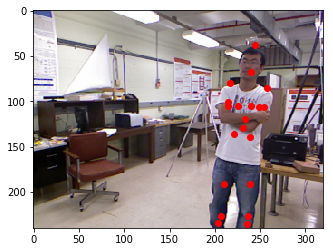

In [6]:
rgb_dir_ = 'UTKinect-Action3D/RGB'
rbg_imgs = read_rgb_imgs(rgb_dir_)

In [7]:
def parse_opencv_xml(xml_path):
    w, h = 0, 0 
    depth_im = None

    tree = ET.parse(xml_path)
    root = tree.getroot()[0]
    for child in root:
        if child.tag == 'width':
            w = int(child.text)
        elif child.tag == 'height':
            h = int(child.text)
        elif child.tag == 'data':
            depth_im = [int(pixel) for pixel in child.text.split()]
            depth_im = np.array(depth_im).reshape((h, w))
    return depth_im

def normalize_grayscale_im(input_im):
    norm_im = (255. * input_im / np.max(input_im)) if np.max(input_im) != 0 else input_im
    return norm_im.astype(int)

def process_depth_imgs(folder_name='.', overlay_skeleton=True):
    for dirName, subdirList, fileList in os.walk(folder_name, topdown=False):
        for fname in fileList:
            if fname.endswith('.xml') and fname.startswith('depthImg'):
                video_id = os.path.basename(os.path.normpath(dirName))
                # print("Video ID: ", video_id)

                frame_num = int(os.path.splitext(fname)[0].split('depthImg')[1])
                # print("Frame #: ", frame_num)

                depth_xml_path = os.path.join(dirName, fname)
                                                
                depth_im = parse_opencv_xml(depth_xml_path)
                depth_im = normalize_grayscale_im(depth_im)
                
                depth_im_path = (os.path.splitext(depth_xml_path)[0]) + '.jpg'
                # imageio.imwrite(depth_im_path, depth_im)
                
                depth_obj = DepthImage(depth_im_path)
                
                skeleton_frames = skeletons[video_id]
                skeleton_coords = skeleton_frames[frame_num]
                
                depth_obj.load_skeleton_pixels(skeleton_coords)
                depth_obj.display_depth_img(overlay_skeleton=True)
                depth_obj.display_skeleton_point_cloud()
#                 x, y = zip(*skeleton_coords)                
#                 if overlay_skeleton:
#                     plt.scatter(x, y, c='r')
#                 plt.imshow(depth_im, cmap='gray')
                return depth_obj 

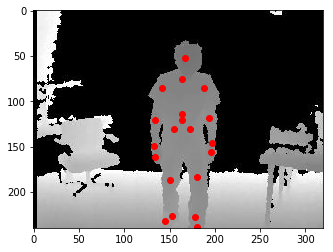

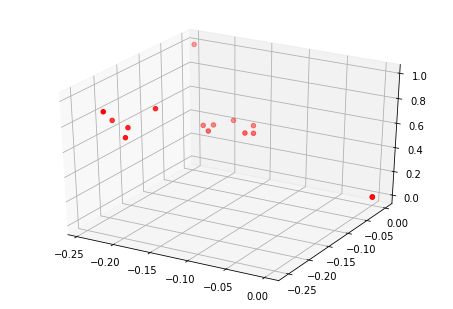

In [8]:
depth_ = 'UTKinect-Action3D/depth'
depth_obj = process_depth_imgs(depth_)

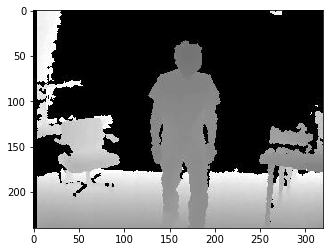

In [9]:
depth_obj.display_depth_img()

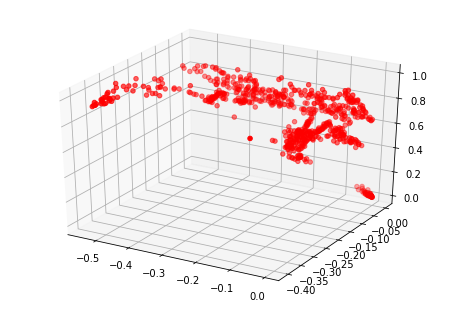

In [11]:
depth_obj.display_point_cloud()